In [1]:
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq
model = ChatGroq(model="llama-3.1-8b-instant")


In [2]:
def multiply(a:int,b:int)->int:
    """Muultiply a and b

    Args:
        a (int): First int
        b (int): Second int

    
    """
    return a*b

def add(a:int,b:int)->int:
    """Addition of a and b

    Args:
        a (int): First int
        b (int): Second int

   
    """
    return a+b

def divide(a:int,b:int)->int:
    """Divide a and b

    Args:
        a (int): First int
        b (int): Second int
   
    """
    return a/b

tools = [add,divide,multiply]  
tools  

[<function __main__.add(a: int, b: int) -> int>,
 <function __main__.divide(a: int, b: int) -> int>,
 <function __main__.multiply(a: int, b: int) -> int>]

In [3]:
##First Way to pass as a List
llm_with_tools = model.bind_tools([add,divide,multiply])
llm_with_tools

llm_with_tools.invoke("What is ai")


##Another way
#llm_with_tools = model.bind_tools(tools)
#tools



AIMessage(content="I don't have specific information about what you're referring to as 'ai'. Can you provide more context about 'ai' or is there a function I can help you with?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 37, 'prompt_tokens': 361, 'total_tokens': 398, 'completion_time': 0.077244655, 'completion_tokens_details': None, 'prompt_time': 0.019875595, 'prompt_tokens_details': None, 'queue_time': 0.055135934, 'total_time': 0.09712025}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_4387d3edbb', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019b2b8f-a842-7cd1-9191-62ffdd3f5701-0', usage_metadata={'input_tokens': 361, 'output_tokens': 37, 'total_tokens': 398})

In [4]:
from langchain_core.messages import HumanMessage,AIMessage
from langgraph.graph import MessagesState


st_msg = AIMessage(content="you are helpful to provide the assistance of arthmetic operations")

def assistance(state:MessagesState):
    return {"messages":[llm_with_tools.invoke([st_msg] + state["messages"])]}

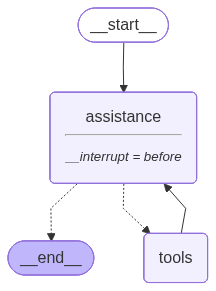

In [5]:
from langgraph.graph import START,END,StateGraph
from IPython.display import Image,display
from langgraph.prebuilt import ToolNode,tools_condition
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

###Define the Graph
graph = StateGraph(MessagesState)

##Define the nodes
graph.add_node("assistance",assistance)
graph.add_node("tools",ToolNode(tools))

##Define the edges
graph.add_edge(START,"assistance")
graph.add_conditional_edges(
    "assistance",
    tools_condition,
    ## If the msg from assistance is a tool call->tools_condition routes the tools
    ## If the msg  from assistance is not a tool call -< tools_conditions routes to END
  
)
graph.add_edge("tools","assistance")

## Add Human Feedback and Memory CheckPointer
graph_builder = graph.compile(interrupt_before=["assistance"],checkpointer=memory)

display(Image(graph_builder.get_graph().draw_mermaid_png()))


In [6]:
config = {
    "configurable":
        {"thread_id":"111"}
}

In [7]:
### Create a Human Message
from pprint import pprint
message = {"messages":HumanMessage(content="Divide 10 and 2")}

for event in graph_builder.stream(message,config,stream_mode="values"):
    event["messages"][-1].pretty_print()


================================ Human Message =================================

Divide 10 and 2


In [8]:
## To see which state is to be exucute next 
state = graph_builder.get_state(config)
state.next

('assistance',)

In [9]:
### Contonue the Exucution
for event in graph_builder.stream(None,config,stream_mode="values"):
    event["messages"][-1].pretty_print()
    

##Why pass as a None --> Because we already pass msg to the llm and tool 

## When Human Interact with llm then llm calls the tools and exucte the input --> when we  pass the "None"(interact with human) LLM provide answer



================================ Human Message =================================

Divide 10 and 2
================================== Ai Message ==================================
Tool Calls:
  divide (zjnegj8pb)
 Call ID: zjnegj8pb
  Args:
    a: 10
    b: 2
================================= Tool Message =================================
Name: divide

5.0


#### Update the State Message

In [13]:
graph_builder.update_state(config,{"messages":[HumanMessage(content="Plz add 15 and 25")]})

{'configurable': {'thread_id': '111',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0db282-a628-6d53-8004-70cc402f9d0c'}}

In [15]:
### See the new State
## To see which state is to be exucute next 
new_state = graph_builder.get_state(config).values

for m in new_state["messages"]:
    m.pretty_print()

================================ Human Message =================================

Divide 10 and 2
================================== Ai Message ==================================
Tool Calls:
  divide (zjnegj8pb)
 Call ID: zjnegj8pb
  Args:
    a: 10
    b: 2
================================= Tool Message =================================
Name: divide

5.0
================================ Human Message =================================

Plz add 15 and 25
================================ Human Message =================================

Plz add 15 and 25


In [17]:
### Contonue the Exucution
for event in graph_builder.stream(None,config,stream_mode="values"):
    event["messages"][-1].pretty_print()
    

##Why pass as a None --> Because we already pass msg to the llm and tool 

## When Human Interact with llm then llm calls the tools and exucte the input --> when we  pass the "None"(interact with human) LLM provide answer



================================ Human Message =================================

Plz add 15 and 25
================================== Ai Message ==================================
Tool Calls:
  add (2rn3hzwnb)
 Call ID: 2rn3hzwnb
  Args:
    a: 15
    b: 25
================================= Tool Message =================================
Name: add

40
